# Forest Fire Burn Area Feature Selection
Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires).

The purpose of this notebook is to perform feature selection on the forest fire burn area dataset, testing its affect on the results. This is a popular regression dataset found on both Kaggle and the UCI Machine Learning Repository. The two data sets are identical, but the one used here was downloaded from UCI. The forest fire weather index (FWI) system features FFMC, DMC, DC and ISI are described [here](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi). The target variable is burn area, which can be predicted by a set of feature variables listed below. The data to be used is already pre-processed by checking for missing values, outliers and converting the categorical features numerical values.

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 0 to 11
4. day - day of the week: 0 to 6
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84


In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit


## Outline of Methods
Features are scored using scikit-learn's feature_selection library. This generates a feature score using either cross-correlation or mutual information. According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) mutual information should not be used for continuous feature variables. Therefore, only f_regression is used here. 

Following this, a regression analysis is performed to determine the effects of features on the regression performance. For this, a model from the decision-tree family is used, as these are blind to the underlying dataset distributions. This is important, as the data is both unnormalized and contains some non-Gaussian distributed features. The performance of the model with each set of features is compared to get an idea of how feature selection can affect model performance.

Lastly, the features are dropped in two sequences. First, they are dropped using the scores derived from sklearn's SelectKBest function. This progression is compared to the built-in feature_importance_ attribute of the tree regressor. 

In [2]:
def feature_eval(data, model, feat_list, cv_splitter, f_score='r2'):
    """ Evaluates the effect of feature selection on model performance. 
    
    This function takes a list of data features, and removes them in ascending
    order of importance, training the model after each feature is removed. 
    The model performance is then evaluated on a test set using sklearn's cross-
    validation function. The data is split by a given method and scored using
    the coefficient of determination (R2) by default, although a different method
    may be selected. 
    
    Parameters
        data: nd.array = the data
        model: sklearn model = the model class used for training and evaluation
        feat_list: list = features in ascending importance
        cv_splitter: sklearn iterator = splitting function from sklearn library
        f_score: str = scoring metric used to evaluate cross-validation
        
    Returns
        score_avg: nd.array = average cross-validation score for each feature set
        score_std: nd.array = standard deviation of scores for each feature set
    """
    
    score_avg = np.zeros(len(feat_list))
    score_std = np.zeros_like(score_avg)
    data_feats = data.copy()
    for i, col in enumerate(feat_list):
        data_feats.drop(columns=col, inplace=True)
        data_nd = data_feats.values
        X_nd, y_nd = data_nd[:, :-1], data_nd[:, -1]
        scores = cross_validate(model, X_nd, y_nd, cv=cv_splitter, scoring=f_score, return_train_score=True)
        score_avg[i] = scores['test_score'].mean()
        score_std[i] = scores['test_score'].std()
        
    return score_avg, score_std


In [3]:
data = pd.read_csv('data/forestfires_preprocessed.csv')
# display(data.head(n=6))


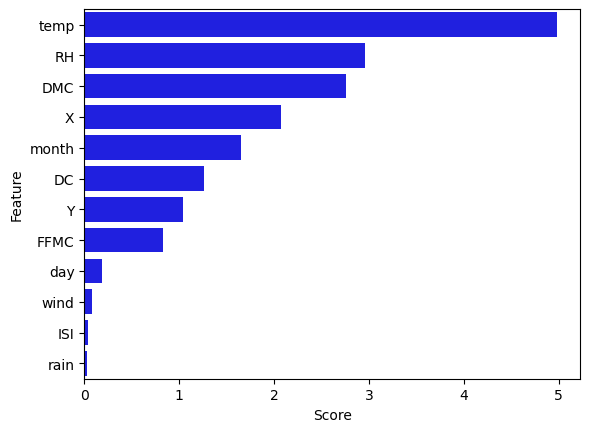

In [4]:
# Score the features using cross-correlation-based f-scoring
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

feature_scores = SelectKBest(score_func=f_regression, k='all')
fit = feature_scores.fit(X, y)
select_feat_scores = pd.DataFrame(fit.scores_)
feat_list = pd.DataFrame(data.columns[:-1])

select_feats = pd.concat([feat_list, select_feat_scores], axis=1)
select_feats.columns = ['Feature', 'Score']
sorted_scores = select_feats.sort_values(['Score'])
sorted_feats = sorted_scores['Feature'][:-1]

sb.barplot(x="Score", y="Feature", data=sorted_scores[::-1], color="b")
plt.show()


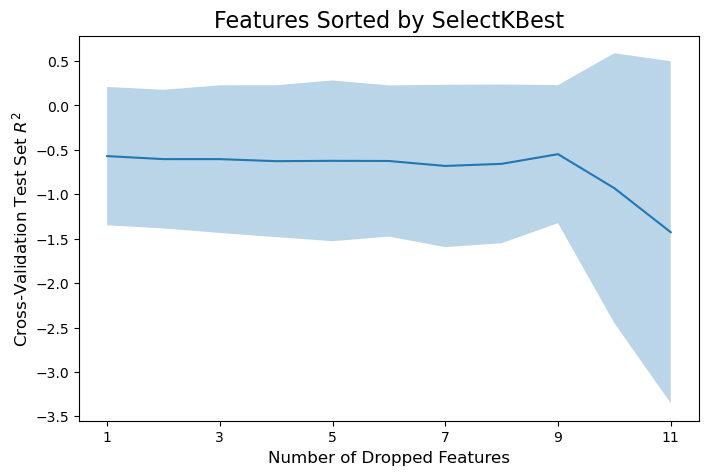

In [5]:
# Perform cross-validation to test the effects of feature selection
model = RandomForestRegressor(random_state=66)
cv_splitter = ShuffleSplit(n_splits=10, test_size=0.2, random_state=66)
avg, std = feature_eval(data, model, sorted_feats, cv_splitter)

# Plot the cross-validation test R2 scores
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(np.arange(avg.size) + 1, avg)
ax.fill_between(np.arange(avg.size) + 1, avg - std, avg + std, alpha=0.3)
ax.set_xticks(np.arange(avg.size + 1)[1::2])
ax.set_xlabel('Number of Dropped Features', fontsize=12)
ax.set_ylabel('Cross-Validation Test Set ' + r'$R^2$', fontsize=12)
ax.set_title('Features Sorted by SelectKBest', fontsize=16);


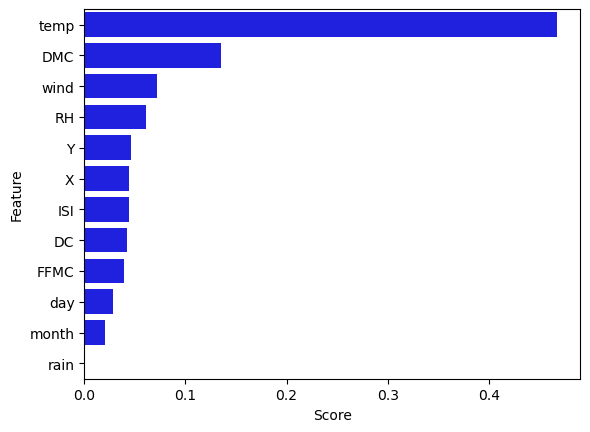

In [6]:
# Compare feature importance to the tree regressor's built-in function
model.fit(X, y)
tree_feats = pd.concat([feat_list, pd.DataFrame(model.feature_importances_)], axis=1)
tree_feats.columns = ['Feature', 'Score']
tree_scores = tree_feats.sort_values(['Score'])
sorted_tree_feats = tree_scores['Feature'][:-1]
sb.barplot(x="Score", y="Feature", data=tree_feats.sort_values(['Score'], ascending=False), color="b")
plt.show()


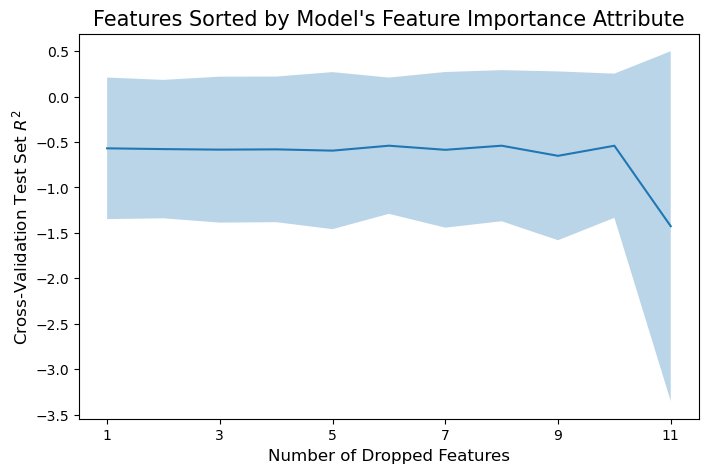

In [7]:
# Compare feature selection scores
avg, std = feature_eval(data, model, sorted_tree_feats, cv_splitter)

# Plot the cross-validation test R2 scores
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(np.arange(avg.size) + 1, avg)
ax.fill_between(np.arange(avg.size) + 1, avg - std, avg + std, alpha=0.3)
ax.set_xticks(np.arange(avg.size + 1)[1::2])
ax.set_xlabel('Number of Dropped Features', fontsize=12)
ax.set_ylabel('Cross-Validation Test Set ' + r'$R^2$', fontsize=12)
ax.set_title('Features Sorted by Model\'s Feature Importance Attribute', fontsize=15);


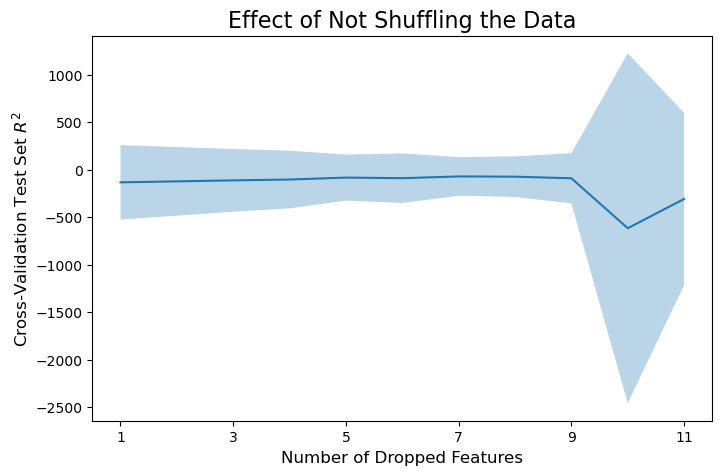

In [8]:
# Compare feature selection scores
avg, std = feature_eval(data, model, sorted_feats, 10)

# Plot the cross-validation test R2 scores
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(np.arange(avg.size) + 1, avg)
ax.fill_between(np.arange(avg.size) + 1, avg - std, avg + std, alpha=0.3)
ax.set_xticks(np.arange(avg.size + 1)[1::2])
ax.set_xlabel('Number of Dropped Features', fontsize=12)
ax.set_ylabel('Cross-Validation Test Set ' + r'$R^2$', fontsize=12)
ax.set_title('Effect of Not Shuffling the Data', fontsize=16);


## Conclusions
The model does not perform particularly well, but that is ok as performance is not the purpose of this study. Additionally, removing features has little effect on the performance until the most imporant one or two. Both of these factors correspond to the lack of correlation between the target variable (burn area) and the feature variables that was observed in the [dataset EDA](./forest_fire_eda.ipynb). We can see that using sklearn's SelectKBest function provides a reasonable first estimate of which features are important. However, after performing a cross-validation analysis using a decision tree regression model, we can see that the feature importance was weighted differently in this model's solution. This indicates that feature importance is somewhat model dependent. This should be kept in mind when pre-processing data in future projects. 

Although there is some model dependence on feature importance, it makes sense that the most important features are going to be important in any model used. A good indication of this is where the drop in $R^2$ performance begins. Using the SelectKBest function, the DMC feature is rated as the third most important, whereas the decision tree model's built-in feature importance attribute ranks it as the second most important. We can see in the performance plots that the $R^2$ score drops off when DMC is first removed. This is an indication that this feature is indeed one of the two most important features. These are the types of changes to look for when performing a feature selection. 

One note that is not directly related to feature selection, but was an important discovery during this analysis is the effect of shuffling the data. When the data is unshuffled, there is a significant drop in both performance and consistency. This was a much more drastic effect than I would have imagined not shuffling the data could have. I am guessing it has to do with the distribution of target values in the unshuffled data, where some folds of the cross validation correspond to a large portion of the informative data, whereas other folds contain very little useful information. This is good to be aware of in future projects
